In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVR
from sklearn.decomposition import PCA

In [2]:
#Load the Train and Test Data
train_data=pd.read_csv('/storage/emulated/0/dataset/train.csv',na_values='NULL')
test_data=pd.read_csv('/storage/emulated/0/dataset/test.csv',na_values='NULL')
id=test_data['Product_id']

In [3]:
#Combine Train and Test Data for Analysis
data=train_data.append(test_data).drop('Selling_Price',axis=1)
y_target=train_data.Selling_Price

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9798 entries, 0 to 3429
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_id        9798 non-null   object 
 1   Stall_no          9792 non-null   float64
 2   instock_date      9798 non-null   object 
 3   Market_Category   9798 non-null   int64  
 4   Customer_name     9534 non-null   object 
 5   Loyalty_customer  9798 non-null   object 
 6   Product_Category  9798 non-null   object 
 7   Grade             9798 non-null   int64  
 8   Demand            9798 non-null   int64  
 9   Discount_avail    9760 non-null   float64
 10  charges_1         9564 non-null   float64
 11  charges_2 (%)     9588 non-null   float64
 12  Minimum_price     9746 non-null   float64
 13  Maximum_price     9455 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 956.8+ KB


<Figure size 216x216 with 0 Axes>

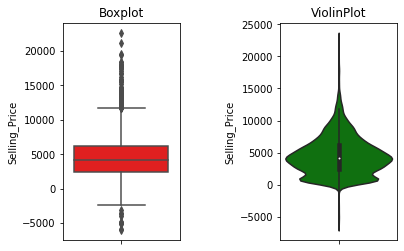

In [5]:
#A glance at the Target Variable
import matplotlib.pyplot as plt;plt.figure(figsize=(3,3))
fig,(ax1,ax2)=plt.subplots(1,2);plt.subplots_adjust(wspace=0.85,hspace=0.85)
ax1.set_title('Boxplot')
ax2.set_title('ViolinPlot')
sns.boxplot(y=train_data.Selling_Price,color='r',orient='v',ax=ax1)
sns.violinplot(y=train_data.Selling_Price,color='g',orient='v',ax=ax2)
plt.show()

The Target Variable 'Selling Price' as can bes seen above Has Negative values and much outliers
we will take the Log to base 10 of its absolute values

In [6]:
data

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price
0,BRAE2NF6JA5GUEXG,37.0,2015-08-22 18:36:12.000,2,Lillyann,Yes,Fashion,1,68,0.0,376.0,11.0,2983.0,4713.0
1,TUNE8SFB6RJN2HSD,38.0,2016-03-27 21:19:13.000,24,Klynn,Yes,Fashion,0,51,0.0,397.0,12.0,7495.0,10352.0
2,BRAEAR7WZPQGPBZU,9.0,2015-08-18 19:25:22.000,447,Ridge,Yes,Child_care,0,10,0.0,250.0,9.0,5752.0,7309.0
3,WATDZ2ZQ8JPDHCTJ,50.0,2016-03-28 21:53:01.000,23,Abran,Yes,Educational,2,48,0.0,144.0,13.0,5090.0,20814.0
4,JWSEBUKYQPMBZ3RK,7.0,2016-03-29 22:58:53.000,63,Dustyn,Yes,Repair,1,35,1.0,211.0,4.0,2430.0,9261.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3425,BBAE9K7BXFUTDNBK,9.0,2015-08-15 21:17:17.000,58,Davion,Yes,Pet_care,0,39,0.0,117.0,5.0,3094.0,4674.0
3426,RTRDYPA4PJHCJCGF,30.0,2015-12-04 01:51:47.000,358,Maiah,Yes,Technology,3,17,0.0,509.0,6.0,3384.0,14105.0
3427,TUNE8FWQBS7TVVT7,14.0,2016-03-28 20:55:47.000,106,Gwendolen,Yes,Educational,0,36,0.0,150.0,17.0,710.0,10894.0
3428,NKCEGMUABCRGUZPE,1.0,2015-05-23 07:41:36.000,104,Addilynn,Yes,Child_care,0,63,0.0,325.0,15.0,1477.0,5165.0


In [7]:
#custom Function to Handle the instock_date column 
def split(Dates):
    f=[];e=0;n=0
    for x in range(len(Dates)):
        u=Dates[x].split('-')
        for y in u:
            if n==1:
                d=int(y)/12
            if n==2:
                d=int(y)/365
            if n==0:
                d=int(y);
            e+=d;n+=1
        f.append(e);e=0;n=0
    return f


In [8]:
instock_dates=[x[:10] for x in data.instock_date]# Trim instock date to Year Month and Day only
instock_dates

['2015-08-22',
 '2016-03-27',
 '2015-08-18',
 '2016-03-28',
 '2016-03-29',
 '2015-09-25',
 '2014-12-08',
 '2015-09-22',
 '2016-03-28',
 '2015-08-19',
 '2015-09-25',
 '2016-03-29',
 '2016-03-29',
 '2016-03-10',
 '2016-03-28',
 '2015-09-25',
 '2015-09-24',
 '2015-09-24',
 '2015-08-19',
 '2016-02-07',
 '2016-03-27',
 '2015-05-06',
 '2015-10-20',
 '2015-09-26',
 '2015-11-20',
 '2015-11-18',
 '2015-05-09',
 '2015-05-07',
 '2015-08-15',
 '2015-08-21',
 '2016-03-01',
 '2015-09-22',
 '2015-08-16',
 '2015-08-19',
 '2015-08-19',
 '2015-08-17',
 '2015-11-19',
 '2015-09-26',
 '2016-03-28',
 '2015-08-15',
 '2016-03-27',
 '2016-03-30',
 '2015-08-18',
 '2015-11-19',
 '2016-03-29',
 '2016-03-29',
 '2015-11-12',
 '2015-11-04',
 '2015-09-16',
 '2015-05-05',
 '2014-11-01',
 '2015-09-25',
 '2016-03-28',
 '2016-03-21',
 '2015-08-17',
 '2015-09-26',
 '2014-02-21',
 '2016-03-30',
 '2015-05-07',
 '2016-03-16',
 '2016-03-29',
 '2015-10-20',
 '2015-11-01',
 '2016-03-29',
 '2015-09-24',
 '2015-09-23',
 '2015-11-

In [9]:
# Apply Custom Function to instock dates
dates_transformed=split(instock_dates)
dates_transformed

[2015.7269406392695,
 2016.3239726027398,
 2015.7159817351599,
 2016.3267123287671,
 2016.3294520547945,
 2015.8184931506848,
 2015.021917808219,
 2015.8102739726028,
 2016.3267123287671,
 2015.7187214611872,
 2015.8184931506848,
 2016.3294520547945,
 2016.3294520547945,
 2016.277397260274,
 2016.3267123287671,
 2015.8184931506848,
 2015.8157534246575,
 2015.8157534246575,
 2015.7187214611872,
 2016.1858447488585,
 2016.3239726027398,
 2015.4331050228311,
 2015.8881278538813,
 2015.8212328767124,
 2015.9714611872148,
 2015.9659817351599,
 2015.4413242009134,
 2015.4358447488585,
 2015.7077625570778,
 2015.7242009132422,
 2016.2527397260274,
 2015.8102739726028,
 2015.7105022831051,
 2015.7187214611872,
 2015.7187214611872,
 2015.7132420091325,
 2015.9687214611872,
 2015.8212328767124,
 2016.3267123287671,
 2015.7077625570778,
 2016.3239726027398,
 2016.3321917808219,
 2015.7159817351599,
 2015.9687214611872,
 2016.3294520547945,
 2016.3294520547945,
 2015.9495433789955,
 2015.927625570

In [10]:
data_copy=data.copy()
data.instock_date=dates_transformed
# Shrink the values of instock_date by subtracting from 2020
data.instock_date=2020-data.instock_date
data.instock_date

 

0       4.273059
1       3.676027
2       4.284018
3       3.673288
4       3.670548
          ...   
3425    4.292237
3426    3.989041
3427    3.673288
3428    4.520320
3429    4.289498
Name: instock_date, Length: 9798, dtype: float64

In [11]:
#Drop less informative columns
col=['Product_id','Stall_no','Customer_name','Loyalty_customer','Demand','Product_Category']
data.drop(col,axis=1,inplace=True)
data

,instock_date,Market_Category,Grade,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price
0,4.273059,2,1,0.0,376.0,11.0,2983.0,4713.0
1,3.676027,24,0,0.0,397.0,12.0,7495.0,10352.0
2,4.284018,447,0,0.0,250.0,9.0,5752.0,7309.0
3,3.673288,23,2,0.0,144.0,13.0,5090.0,20814.0
4,3.670548,63,1,1.0,211.0,4.0,2430.0,9261.0
...,...,...,...,...,...,...,...,...
3425,4.292237,58,0,0.0,117.0,5.0,3094.0,4674.0
3426,3.989041,358,3,0.0,509.0,6.0,3384.0,14105.0
3427,3.673288,106,0,0.0,150.0,17.0,710.0,10894.0
3428,4.520320,104,0,0.0,325.0,15.0,1477.0,5165.0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9798 entries, 0 to 3429
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   instock_date     9798 non-null   float64
 1   Market_Category  9798 non-null   int64  
 2   Grade            9798 non-null   int64  
 3   Discount_avail   9760 non-null   float64
 4   charges_1        9564 non-null   float64
 5   charges_2 (%)    9588 non-null   float64
 6   Minimum_price    9746 non-null   float64
 7   Maximum_price    9455 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 688.9 KB


In [13]:
data.Discount_avail.value_counts()

0.0    8369
1.0    1391
Name: Discount_avail, dtype: int64

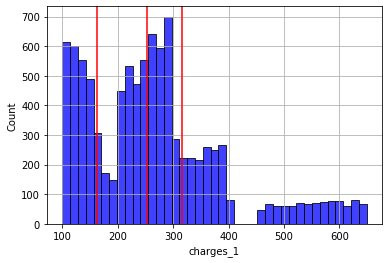

In [14]:
#Hist plot of Charges_1
sns.histplot(data.charges_1,color='b')
plt.grid('True')
for x in [0.25,0.5,0.75]:
    plt.axvline(data.charges_1.quantile(x),c='r',lw=1.5)
plt.show()

In [15]:
data['charges_2 (%)'].describe()

count    9588.000000
mean       10.249791
std         4.289862
min         1.000000
25%         7.000000
50%        10.000000
75%        14.000000
max        17.000000
Name: charges_2 (%), dtype: float64

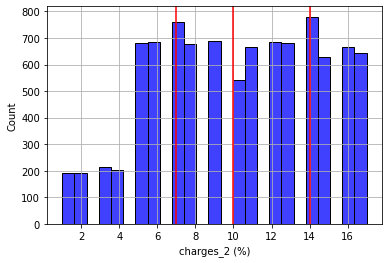

In [16]:
#Hist plot of charges_2 (%)
sns.histplot(data['charges_2 (%)'],color='b')
plt.grid('True')
for x in [0.25,0.50,0.75]:
    plt.axvline(data['charges_2 (%)'].quantile(x),color='r',lw=1.5)
plt.show()

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9798 entries, 0 to 3429
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   instock_date     9798 non-null   float64
 1   Market_Category  9798 non-null   int64  
 2   Grade            9798 non-null   int64  
 3   Discount_avail   9760 non-null   float64
 4   charges_1        9564 non-null   float64
 5   charges_2 (%)    9588 non-null   float64
 6   Minimum_price    9746 non-null   float64
 7   Maximum_price    9455 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 688.9 KB


In [18]:
data.Minimum_price.describe()

count     9746.000000
mean      3500.805664
std       2189.309453
min          1.000000
25%       1862.000000
50%       3124.000000
75%       4668.000000
max      17580.000000
Name: Minimum_price, dtype: float64

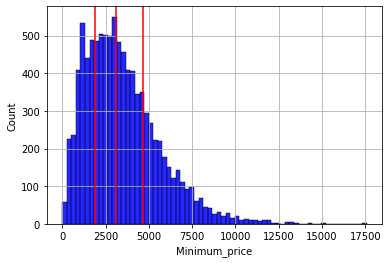

In [19]:
# Hist plot of Minimum Price
sns.histplot(data.Minimum_price,color='b',alpha=0.85)
plt.grid('True')
for x in [0.25,0.50,0.75]:
    plt.axvline(data.Minimum_price.quantile(x),c='r',lw=1.5)
plt.show()

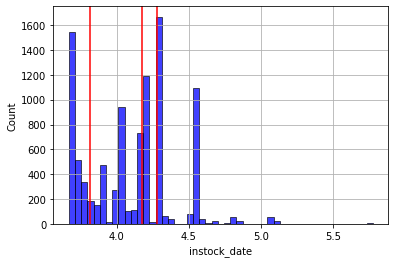

In [20]:
#Hist plot of instock date
sns.histplot(data.instock_date,color='b')
plt.grid('True')
for x in [0.25,0.50,0.75]:
    plt.axvline(data.instock_date.quantile(x),c='r',lw=1.5)
plt.show()

In [21]:
# Fill Discount_avail with 0.0
data.Discount_avail.fillna(0.0,inplace=True)

In [22]:
#Fill every other columns with Mean of its values   
for x in data.columns:
    data[x].fillna(data[x].mean(),inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9798 entries, 0 to 3429
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   instock_date     9798 non-null   float64
 1   Market_Category  9798 non-null   int64  
 2   Grade            9798 non-null   int64  
 3   Discount_avail   9798 non-null   float64
 4   charges_1        9798 non-null   float64
 5   charges_2 (%)    9798 non-null   float64
 6   Minimum_price    9798 non-null   float64
 7   Maximum_price    9798 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 688.9 KB


charges_2 (%) is taken as a percentage of the Maximum value

In [23]:
data['charges_2 (%)']=(data['charges_2 (%)']/100)*data['Maximum_price']
data

,instock_date,Market_Category,Grade,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price
0,4.273059,2,1,0.0,376.0,518.43,2983.0,4713.0
1,3.676027,24,0,0.0,397.0,1242.24,7495.0,10352.0
2,4.284018,447,0,0.0,250.0,657.81,5752.0,7309.0
3,3.673288,23,2,0.0,144.0,2705.82,5090.0,20814.0
4,3.670548,63,1,1.0,211.0,370.44,2430.0,9261.0
...,...,...,...,...,...,...,...,...
3425,4.292237,58,0,0.0,117.0,233.70,3094.0,4674.0
3426,3.989041,358,3,0.0,509.0,846.30,3384.0,14105.0
3427,3.673288,106,0,0.0,150.0,1851.98,710.0,10894.0
3428,4.520320,104,0,0.0,325.0,774.75,1477.0,5165.0


Mean_Price=(maximun_price+mininum_price)/2

In [24]:
data['Mean_Price']=data['Minimum_price']+data['Maximum_price']
data

,instock_date,Market_Category,Grade,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Mean_Price
0,4.273059,2,1,0.0,376.0,518.43,2983.0,4713.0,7696.0
1,3.676027,24,0,0.0,397.0,1242.24,7495.0,10352.0,17847.0
2,4.284018,447,0,0.0,250.0,657.81,5752.0,7309.0,13061.0
3,3.673288,23,2,0.0,144.0,2705.82,5090.0,20814.0,25904.0
4,3.670548,63,1,1.0,211.0,370.44,2430.0,9261.0,11691.0
...,...,...,...,...,...,...,...,...,...
3425,4.292237,58,0,0.0,117.0,233.70,3094.0,4674.0,7768.0
3426,3.989041,358,3,0.0,509.0,846.30,3384.0,14105.0,17489.0
3427,3.673288,106,0,0.0,150.0,1851.98,710.0,10894.0,11604.0
3428,4.520320,104,0,0.0,325.0,774.75,1477.0,5165.0,6642.0


Custom_Price=charges_1+charges_2+mean_price

In [25]:
data['Custom_Price']=data['charges_1']+data['charges_2 (%)']+data['Mean_Price']
data

,instock_date,Market_Category,Grade,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Mean_Price,Custom_Price
0,4.273059,2,1,0.0,376.0,518.43,2983.0,4713.0,7696.0,8590.43
1,3.676027,24,0,0.0,397.0,1242.24,7495.0,10352.0,17847.0,19486.24
2,4.284018,447,0,0.0,250.0,657.81,5752.0,7309.0,13061.0,13968.81
3,3.673288,23,2,0.0,144.0,2705.82,5090.0,20814.0,25904.0,28753.82
4,3.670548,63,1,1.0,211.0,370.44,2430.0,9261.0,11691.0,12272.44
...,...,...,...,...,...,...,...,...,...,...
3425,4.292237,58,0,0.0,117.0,233.70,3094.0,4674.0,7768.0,8118.70
3426,3.989041,358,3,0.0,509.0,846.30,3384.0,14105.0,17489.0,18844.30
3427,3.673288,106,0,0.0,150.0,1851.98,710.0,10894.0,11604.0,13605.98
3428,4.520320,104,0,0.0,325.0,774.75,1477.0,5165.0,6642.0,7741.75


express charges_1 as a percentage of the custom_price

In [26]:
data['charges_1']=(data['charges_1']/data['Custom_Price'])*100
data

,instock_date,Market_Category,Grade,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Mean_Price,Custom_Price
0,4.273059,2,1,0.0,4.376964,518.43,2983.0,4713.0,7696.0,8590.43
1,3.676027,24,0,0.0,2.037335,1242.24,7495.0,10352.0,17847.0,19486.24
2,4.284018,447,0,0.0,1.789701,657.81,5752.0,7309.0,13061.0,13968.81
3,3.673288,23,2,0.0,0.500803,2705.82,5090.0,20814.0,25904.0,28753.82
4,3.670548,63,1,1.0,1.719300,370.44,2430.0,9261.0,11691.0,12272.44
...,...,...,...,...,...,...,...,...,...,...
3425,4.292237,58,0,0.0,1.441117,233.70,3094.0,4674.0,7768.0,8118.70
3426,3.989041,358,3,0.0,2.701082,846.30,3384.0,14105.0,17489.0,18844.30
3427,3.673288,106,0,0.0,1.102456,1851.98,710.0,10894.0,11604.0,13605.98
3428,4.520320,104,0,0.0,4.198017,774.75,1477.0,5165.0,6642.0,7741.75


In [27]:
#Split into train and test data
train_data=data.iloc[:6368]
test_data=data.iloc[6368:]
print('train_data',train_data.shape,'\n','test_data',test_data.shape)


train_data (6368, 10) 
 test_data (3430, 10)


In [28]:
train_data

,instock_date,Market_Category,Grade,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Mean_Price,Custom_Price
0,4.273059,2,1,0.0,4.376964,518.43,2983.0,4713.0,7696.0,8590.43
1,3.676027,24,0,0.0,2.037335,1242.24,7495.0,10352.0,17847.0,19486.24
2,4.284018,447,0,0.0,1.789701,657.81,5752.0,7309.0,13061.0,13968.81
3,3.673288,23,2,0.0,0.500803,2705.82,5090.0,20814.0,25904.0,28753.82
4,3.670548,63,1,1.0,1.719300,370.44,2430.0,9261.0,11691.0,12272.44
...,...,...,...,...,...,...,...,...,...,...
6363,3.673288,24,0,0.0,2.898879,1126.60,8174.0,11266.0,19440.0,21180.60
6364,4.803196,55,0,0.0,2.989221,246.00,3564.0,4920.0,8484.0,8999.00
6365,4.031279,358,3,0.0,1.371229,438.42,5303.0,14614.0,19917.0,20638.42
6366,3.978082,452,0,0.0,2.512830,175.47,4334.0,5849.0,10183.0,10625.47


In [29]:
#Use PCA to reduce Features for Visualization
pca=PCA(n_components=2)
pca.fit(train_data)
print('explained_variance_ratio',pca.explained_variance_ratio_)
z=pca.transform(train_data)[:,0]
print('PCA',z.shape)

explained_variance_ratio [0.96954273 0.02797633]
PCA (6368,)


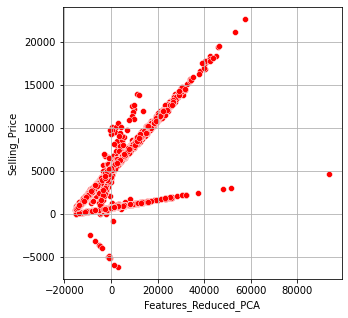

In [30]:
plt.figure(figsize=(5,5))
sns.scatterplot(x=z,y=y_target,color='r')
plt.xlabel('Features_Reduced_PCA')
plt.grid('True')
plt.show()

In [31]:
# Combine Train_data and Target
train_data['Selling_Price']=y_target
train_data

<ipython-input-31-88018bdb61e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Selling_Price']=y_target


,instock_date,Market_Category,Grade,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Mean_Price,Custom_Price,Selling_Price
0,4.273059,2,1,0.0,4.376964,518.43,2983.0,4713.0,7696.0,8590.43,4185.947700
1,3.676027,24,0,0.0,2.037335,1242.24,7495.0,10352.0,17847.0,19486.24,9271.490256
2,4.284018,447,0,0.0,1.789701,657.81,5752.0,7309.0,13061.0,13968.81,6785.701362
3,3.673288,23,2,0.0,0.500803,2705.82,5090.0,20814.0,25904.0,28753.82,13028.917824
4,3.670548,63,1,1.0,1.719300,370.44,2430.0,9261.0,11691.0,12272.44,906.553935
...,...,...,...,...,...,...,...,...,...,...,...
6363,3.673288,24,0,0.0,2.898879,1126.60,8174.0,11266.0,19440.0,21180.60,10277.520192
6364,4.803196,55,0,0.0,2.989221,246.00,3564.0,4920.0,8484.0,8999.00,4501.837200
6365,4.031279,358,3,0.0,1.371229,438.42,5303.0,14614.0,19917.0,20638.42,10218.878775
6366,3.978082,452,0,0.0,2.512830,175.47,4334.0,5849.0,10183.0,10625.47,5359.493997


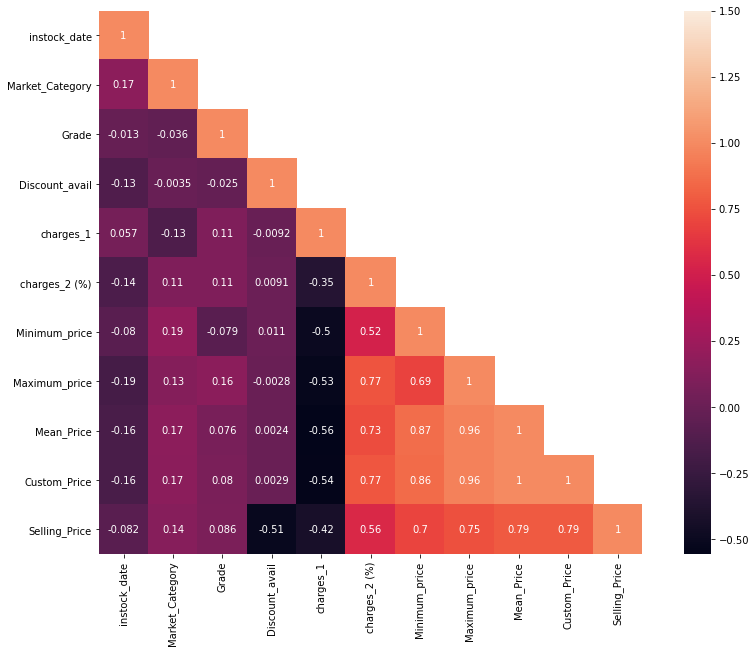

In [32]:
# Heatmap of Train_Data for Correlations
corrmat=train_data.corr();plt.figure(figsize=(15,10))
mask=np.array(corrmat)
mask[np.tril_indices_from(mask)]=False
sns.heatmap(corrmat,mask=mask,annot=True,vmax=1.50,square=True)
plt.xticks(rotation=90)
plt.show()

In [33]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6368 entries, 0 to 6367
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   instock_date     6368 non-null   float64
 1   Market_Category  6368 non-null   int64  
 2   Grade            6368 non-null   int64  
 3   Discount_avail   6368 non-null   float64
 4   charges_1        6368 non-null   float64
 5   charges_2 (%)    6368 non-null   float64
 6   Minimum_price    6368 non-null   float64
 7   Maximum_price    6368 non-null   float64
 8   Mean_Price       6368 non-null   float64
 9   Custom_Price     6368 non-null   float64
 10  Selling_Price    6327 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 597.0 KB


In [34]:
#Drop rows with missing values in target
train_data=train_data[train_data.Selling_Price.notnull()]
print(train_data.info())
y_target=train_data['Selling_Price']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6327 entries, 0 to 6367
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   instock_date     6327 non-null   float64
 1   Market_Category  6327 non-null   int64  
 2   Grade            6327 non-null   int64  
 3   Discount_avail   6327 non-null   float64
 4   charges_1        6327 non-null   float64
 5   charges_2 (%)    6327 non-null   float64
 6   Minimum_price    6327 non-null   float64
 7   Maximum_price    6327 non-null   float64
 8   Mean_Price       6327 non-null   float64
 9   Custom_Price     6327 non-null   float64
 10  Selling_Price    6327 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 593.2 KB
None


In [35]:
train_data.drop('Selling_Price',axis=1,inplace=True)


/data/user/0/ru.iiec.pydroid3/files/arm-linux-androideabi/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [36]:
#Convert Selected Columns to their log in base 10
cols=['instock_date','Market_Category','charges_2 (%)','Minimum_price','Maximum_price','Mean_Price','Custom_Price']
for x in cols:
    train_data[x]=np.log10(np.abs(train_data[x]+1))
    test_data[x]=np.log10(np.abs(test_data[x]+1))
    data[x]=np.log10(np.abs(data[x]+1))
train_data

<ipython-input-36-925868d6d1dc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[x]=np.log10(np.abs(train_data[x]+1))
<ipython-input-36-925868d6d1dc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[x]=np.log10(np.abs(test_data[x]+1))


,instock_date,Market_Category,Grade,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Mean_Price,Custom_Price
0,0.722063,0.477121,1,0.0,4.376964,2.715527,3.474799,3.673390,3.886321,3.934065
1,0.669877,1.397940,0,0.0,2.037335,3.094555,3.874830,4.015066,4.251590,4.289750
2,0.722964,2.651278,0,0.0,1.789701,2.818760,3.759894,3.863917,4.116010,4.145190
3,0.669623,1.380211,2,0.0,0.500803,3.432459,3.706803,4.318376,4.413384,4.458711
4,0.669368,1.806180,1,1.0,1.719300,2.569889,3.385785,3.966705,4.067889,4.088966
...,...,...,...,...,...,...,...,...,...,...
6363,0.669623,1.397940,0,0.0,2.898879,3.052155,3.912488,4.051808,4.288719,4.325959
6364,0.763667,1.748188,0,0.0,2.989221,2.392697,3.552060,3.692053,3.928652,3.954243
6365,0.701678,2.555094,3,0.0,1.371229,2.642880,3.724604,4.164799,4.299246,4.314697
6366,0.697062,2.656098,0,0.0,2.512830,2.246671,3.636989,3.767156,4.007918,4.026389


In [37]:
#Log of absolute value of target
y_target=np.log10(np.abs(y_target))
y_target

0       3.621794
1       3.967150
2       3.831595
3       4.114908
4       2.957394
          ...   
6363    4.011888
6364    3.653390
6365    4.009403
6366    3.729124
6367    3.717672
Name: Selling_Price, Length: 6327, dtype: float64

In [38]:
#Standard Scaling
scaler=StandardScaler()
scaler.fit(data)
train=scaler.transform(train_data)
test=scaler.transform(test_data)
print('train',train.shape,'\n','test',test.shape)

train (6327, 10) 
 test (3430, 10)


In [39]:
#SVR from sklearn.svm
svm_reg=SVR(C=10,epsilon=0.01,kernel='linear')
svm_reg.fit(train,y_target)

SVR(C=10, epsilon=0.01, kernel='linear')

In [40]:
test_pre=(10**svm_reg.predict(test))
test_pre

array([ 3350.01107334,  1952.69938441, 11807.01944011, ...,
        5896.57345327,  3551.69655384,  1008.26897607])

In [49]:
#Preparing submission file
sub_file=pd.DataFrame()
sub_file['Product_id']=id
sub_file['Selling_Price']=(10**svm_reg.predict(test))
fh=sub_file.to_csv('Halloween_Prediction.csv',index=False)
sub_file

,Product_id,Selling_Price
0,SCHE4YSTDVPVZVXW,3350.011073
1,ACCEGCATKHNRXUHW,1952.699384
2,NKCE6GJ5XVJDXNNZ,11807.019440
3,NKCEB8BK3ZXDHDHM,9472.624514
4,TOPEFDXSAHRNPF94,5683.755266
...,...,...
3425,BBAE9K7BXFUTDNBK,3961.500303
3426,RTRDYPA4PJHCJCGF,9079.526764
3427,TUNE8FWQBS7TVVT7,5896.573453
3428,NKCEGMUABCRGUZPE,3551.696554
